In [0]:
import os
import numpy as np
import time

import matplotlib.pyplot as plt

In [0]:
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms, datasets, models

## Load data to Colab

In [0]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#     print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

Saving models.py to models.py
User uploaded file "models.py" with length 1619 bytes


In [1]:
# !unzip -q lfw_with_more_than_2_pic.zip
# !ls

lfw_with_more_than_2_pic  lfw_with_more_than_2_pic.zip	sample_data


## Read Images

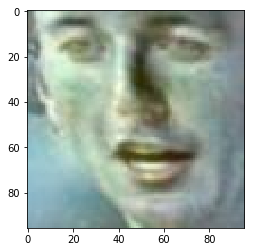

In [0]:
image = cv2.imread('./lfw_align_normalized_test/Aaron_Peirsol/Aaron_Peirsol_1184.jpg')
plt.imshow(image)

In [0]:
mean = cv2.imread('mean.jpg')
std = cv2.imread('stddev.jpg')

In [0]:
# data_dir = os.getcwd()

In [0]:
data_dir = "./lfw_with_more_than_2_pic"

In [0]:
IMAGE_WIDTH = 96
IMAGE_HEIGHT = 96
COLOR_CHANNELS = 3

TOTAL_IMAGES_NUMBER = 9164
TRAIN_IMAGES_NUMBER = 6159
TEST_IMAGES_NUMBER = 3005

NUMBER_OF_PERSONS = 1680

BATCH_SIZE = 100

In [0]:
data_transforms = {
    'train': transforms.Compose([       
        transforms.ToTensor(),     
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

### Load data

In [0]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

# special class for loading data in the form of batches
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=4)
               
               for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

In [59]:
print(dataset_sizes)

{'train': 6159, 'test': 3005}


In [0]:
classes_train = image_datasets['train'].classes
classes_test = image_datasets['test'].classes

In [61]:
len(classes_test)

1680

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    losses = {'train': [], 'test': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.train(False)  # установить модель в режим предсказания

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in dataloaders[phase]:
                # получаем картинки и метки
                inputs, labels = data

                inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                optimizer.zero_grad()

                # forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

Функция для отрисовки тестовых изображений и предсказаний для них:

In [0]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['test']):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

Функция для измерения точности модели на валидационном датасете

In [0]:
def evaluate(model):
    model.train(False)
    
    runninig_correct = 0
    for data in dataloaders['test']:
        # получаем картинки и метки
        inputs, labels = data
                    
        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['test']

## AlexNet

In [0]:
model = models.alexnet(pretrained=True)

In [218]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [0]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier = nn.Linear(num_features, NUMBER_OF_PERSONS)

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=40)

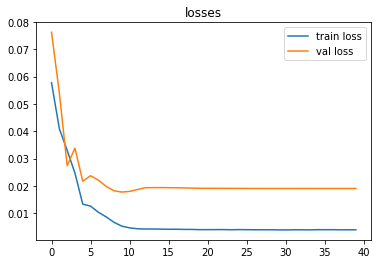

In [221]:
plt.title("losses")
plt.plot(losses['train'], label="train loss")
plt.plot(losses['test'], label="val loss")
plt.legend() #Place a legend on the axes.

In [0]:
torch.save(model.state_dict(), 'AlexNet_fine_tune.pth')

In [0]:
model.load_state_dict(torch.load('AlexNet_fine_tune.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
print("Accuracy: {0:.4f}".format(evaluate(model)))

Accuracy: 0.2455


In [0]:
model_extractor = models.alexnet(pretrained=True)

In [0]:
for param in model_extractor.parameters():
    print(param.requires_grad)

In [0]:
# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, NUMBER_OF_PERSONS)

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
%%time
model_extractor,losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=40)

In [0]:
%%time
model_extractor,losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=40)

In [25]:
model_mixed = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:02<00:00, 103105523.45it/s]


In [0]:
layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_mixed.classifier = nn.Linear(num_features, NUMBER_OF_PERSONS)

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой 
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
optimizer = optim.SGD(list(model_mixed.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_mixed.classifier.parameters()), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
%%time
_, losses = train_model(model_mixed, loss_fn, optimizer, exp_lr_scheduler, num_epochs=100)

## VGG16

In [0]:
model_extractor = models.vgg16(pretrained=True)

In [0]:
# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, NUMBER_OF_PERSONS)


# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.0678 Acc: 0.0677
test Loss: 0.0667 Acc: 0.0879

Epoch 1/49
----------


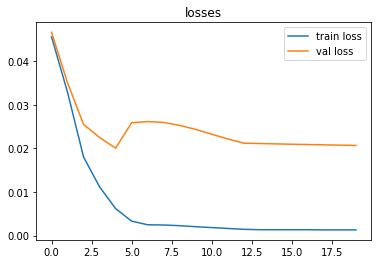

In [224]:
plt.title("losses")
plt.plot(losses['train'], label="train loss")
plt.plot(losses['test'], label="val loss")
plt.legend() #Place a legend on the axes.

In [0]:
torch.save(model.state_dict(), 'VGG16_fine_tune.pth')

In [190]:
model.load_state_dict(torch.load('VGG16_fine_tune.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [192]:
print("Accuracy: {0:.4f}".format(evaluate(model)))

Accuracy: 0.2455
